In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import os

In [3]:
SEED = 20240212
BATCH_SIZE_V1 = 32
BATCH_SIZE_V2 = 64
LEARNING_RATE = 0.0001
EPOCHS = 15
TARGET_ACCURACY = 88.0

os.makedirs('results', exist_ok=True)

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device set to: {device}")
print(f"✅ Seed set to: {SEED}")


✅ Device set to: cuda
✅ Seed set to: 20240212


In [4]:
gtsrb_classes = {
    1:  'Speed limit (30km/h)',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    17: 'No entry',
    18: 'General caution',
    25: 'Road work',
    33: 'Turn right ahead',
    35: 'Ahead only',
    38: 'Keep right'
}

In [5]:
classes_to_keep = list(gtsrb_classes.keys())
print(f"Selected Classes IDs: {classes_to_keep}")

label_map = {original: new for new, original in enumerate(classes_to_keep)}
inv_label_map = {new: gtsrb_classes[original] for original, new in label_map.items()}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))
])

train_full = torchvision.datasets.GTSRB(root='./data', split='train', download=True, transform=transform)
test_full = torchvision.datasets.GTSRB(root='./data', split='test', download=True, transform=transform)

Selected Classes IDs: [1, 12, 13, 14, 17, 18, 25, 33, 35, 38]


100%|██████████| 187M/187M [00:10<00:00, 17.6MB/s]
100%|██████████| 89.0M/89.0M [00:08<00:00, 11.0MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 210kB/s]


In [6]:
def filter_dataset(dataset, target_classes):
    indices = []

    for idx, (path, label) in enumerate(dataset._samples):
        if label in target_classes:
            indices.append(idx)
    return Subset(dataset, indices)

print("🔍 Filtering dataset to 10 classes...")
train_subset = filter_dataset(train_full, classes_to_keep)
test_subset = filter_dataset(test_full, classes_to_keep)

print(f"✅ Train samples: {len(train_subset)}")
print(f"✅ Test samples: {len(test_subset)}")

def mapped_collate(batch):
    imgs, labels = zip(*batch)
    imgs = torch.stack(imgs)
    new_labels = torch.tensor([label_map[l] for l in labels], dtype=torch.long)
    return imgs, new_labels


🔍 Filtering dataset to 10 classes...
✅ Train samples: 10140
✅ Test samples: 4920


In [7]:
def get_model():

    model = models.mobilenet_v2(weights='IMAGENET1K_V1')

    for param in model.parameters():
        param.requires_grad = False

    model.classifier[1] = nn.Linear(1280, 10)

    return model.to(device)

In [8]:
def train_model(version_name, batch_size, lr, num_epochs):
    print(f"\n🚀 STARTING {version_name} | Batch: {batch_size} | LR: {lr}")

    model = get_model()

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=mapped_collate)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=mapped_collate)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    history = {'train_acc': [], 'test_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_correct = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            running_correct += (predicted == labels).sum().item()

        train_acc = 100 * running_correct / total_train

        model.eval()
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_acc = 100 * correct_test / total_test

        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

        print(f"   Epoch {epoch+1}/{num_epochs} | Train: {train_acc:.2f}% | Test: {test_acc:.2f}%")

    return history, model, test_acc


In [9]:
hist_v1, model_v1, acc_v1 = train_model("Version 1", BATCH_SIZE_V1, LEARNING_RATE, EPOCHS)
hist_v2, model_v2, acc_v2 = train_model("Version 2", BATCH_SIZE_V2, LEARNING_RATE, EPOCHS)

if acc_v1 >= acc_v2:
    best_model = model_v1
    best_version = "Version 1"
    best_acc = acc_v1
    best_hist = hist_v1
else:
    best_model = model_v2
    best_version = "Version 2"
    best_acc = acc_v2
    best_hist = hist_v2


🚀 STARTING Version 1 | Batch: 32 | LR: 0.0001
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 65.4MB/s]


   Epoch 1/15 | Train: 61.25% | Test: 76.63%
   Epoch 2/15 | Train: 86.61% | Test: 82.76%
   Epoch 3/15 | Train: 90.84% | Test: 86.16%
   Epoch 4/15 | Train: 93.15% | Test: 87.24%
   Epoch 5/15 | Train: 94.24% | Test: 87.76%
   Epoch 6/15 | Train: 94.60% | Test: 89.13%
   Epoch 7/15 | Train: 95.18% | Test: 88.84%
   Epoch 8/15 | Train: 95.81% | Test: 89.37%
   Epoch 9/15 | Train: 96.11% | Test: 90.00%
   Epoch 10/15 | Train: 96.10% | Test: 90.47%
   Epoch 11/15 | Train: 96.63% | Test: 91.10%
   Epoch 12/15 | Train: 96.51% | Test: 90.77%
   Epoch 13/15 | Train: 96.59% | Test: 91.20%
   Epoch 14/15 | Train: 96.93% | Test: 91.71%
   Epoch 15/15 | Train: 96.95% | Test: 90.93%

🚀 STARTING Version 2 | Batch: 64 | LR: 0.0001
   Epoch 1/15 | Train: 53.51% | Test: 73.58%
   Epoch 2/15 | Train: 82.53% | Test: 79.74%
   Epoch 3/15 | Train: 88.99% | Test: 82.54%
   Epoch 4/15 | Train: 91.40% | Test: 84.02%
   Epoch 5/15 | Train: 92.97% | Test: 86.08%
   Epoch 6/15 | Train: 93.86% | Test: 87.26%
  

✅ Saved results/training_comparison.png


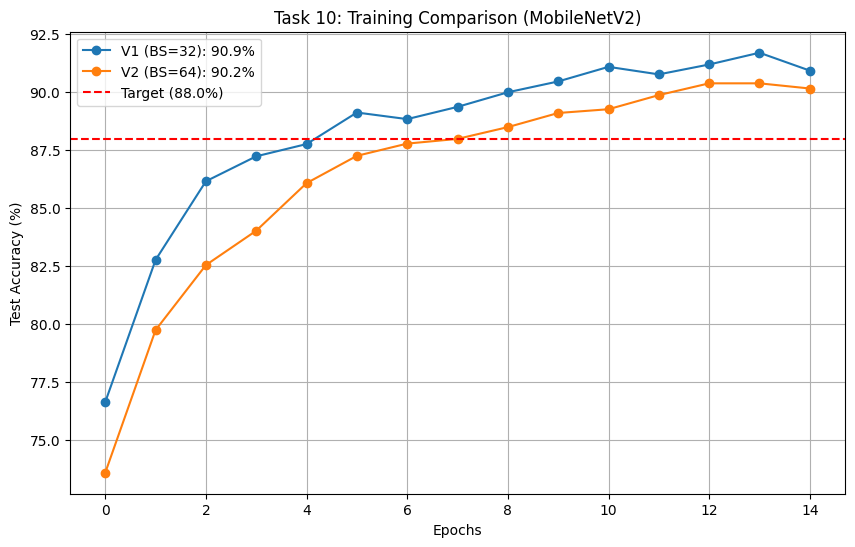

✅ Saved results/confusion_matrix.png


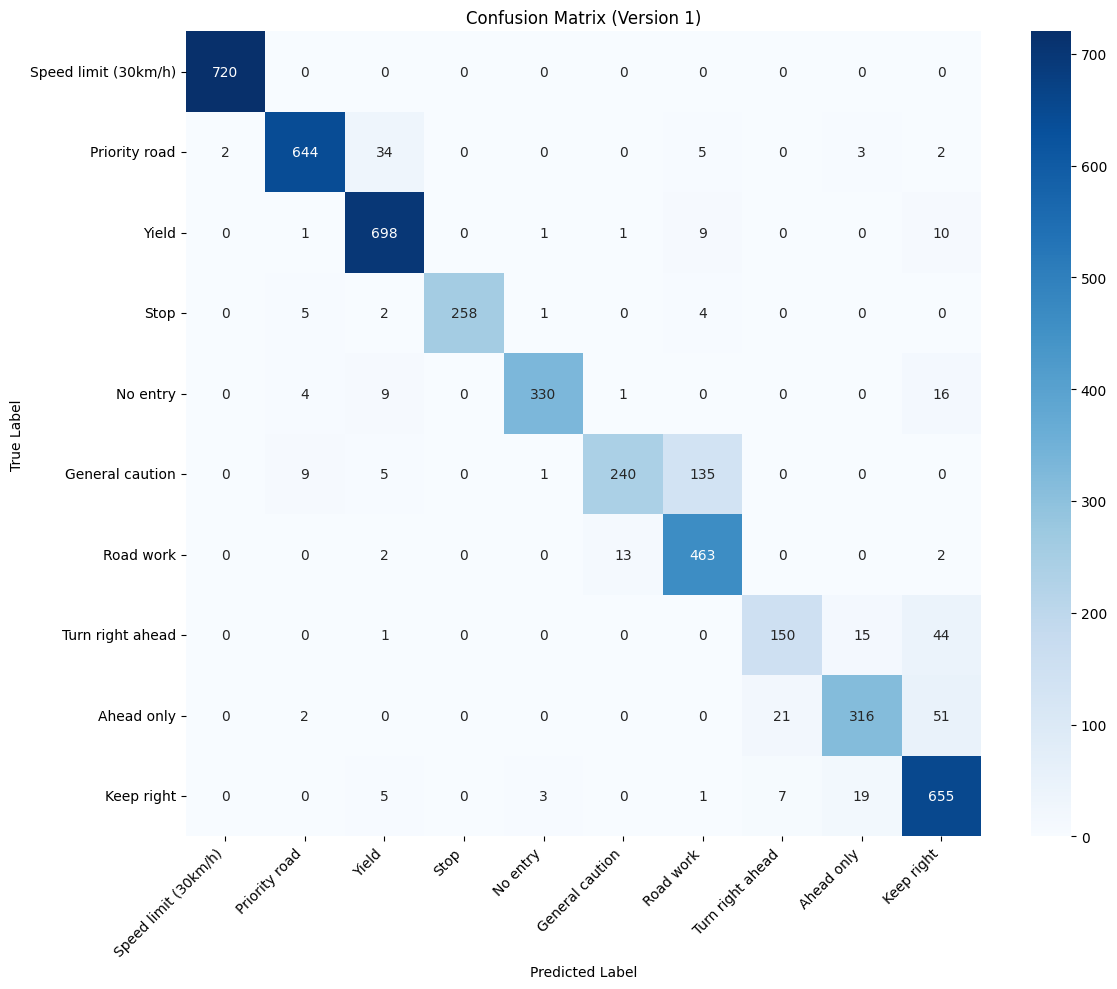

✅ Saved results/predictions.png


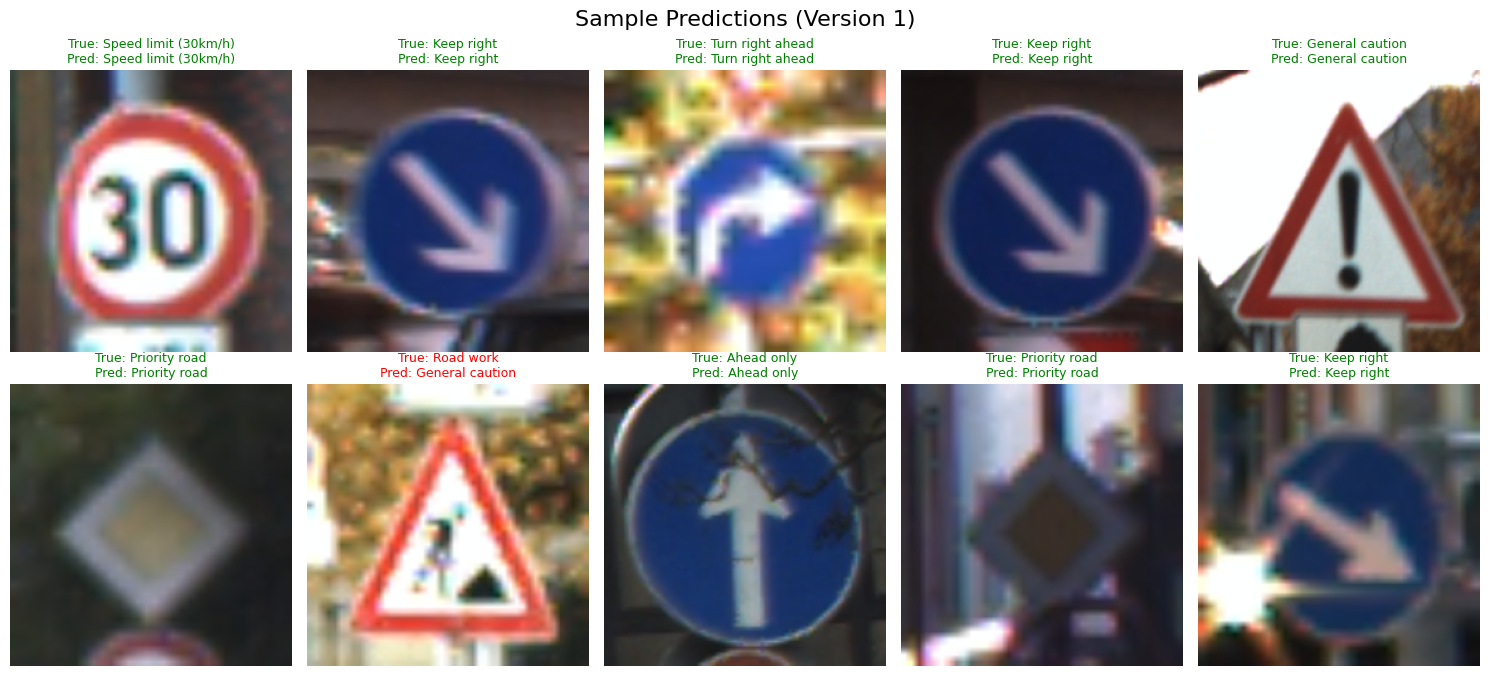


🎉 ALL TASKS COMPLETE. CHECK 'results/' FOLDER.


In [17]:
plt.figure(figsize=(10, 6))
plt.plot(hist_v1['test_acc'], label=f'V1 (BS=32): {acc_v1:.1f}%', marker='o')
plt.plot(hist_v2['test_acc'], label=f'V2 (BS=64): {acc_v2:.1f}%', marker='o')
plt.title(f"Task 10: Training Comparison (MobileNetV2)")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.axhline(y=TARGET_ACCURACY, color='r', linestyle='--', label=f'Target ({TARGET_ACCURACY}%)')
plt.legend()
plt.grid(True)
plt.savefig('results/training_comparison.png')
print("✅ Saved results/training_comparison.png")
plt.show()

best_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=mapped_collate)
y_pred = []
y_true = []

best_model.eval()
with torch.no_grad():
    for inputs, labels in best_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[inv_label_map[i] for i in range(10)],
            yticklabels=[inv_label_map[i] for i in range(10)])
plt.title(f'Confusion Matrix ({best_version})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('results/confusion_matrix.png')
print("✅ Saved results/confusion_matrix.png")
plt.show()

data_iter = iter(best_loader)
images, labels = next(data_iter)
images = images[:10].to(device)
labels = labels[:10]

outputs = best_model(images)
_, preds = torch.max(outputs, 1)

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

fig, axes = plt.subplots(2, 5, figsize=(15, 7))
fig.suptitle(f"Sample Predictions ({best_version})", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = std * img + mean
    img = np.clip(img, 0, 1)

    true_name = inv_label_map[labels[i].item()]
    pred_name = inv_label_map[preds[i].item()]

    ax.imshow(img)
    color = 'green' if labels[i] == preds[i] else 'red'
    ax.set_title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.savefig('results/predictions.png')
print("✅ Saved results/predictions.png")
plt.show()

print("\n🎉 ALL TASKS COMPLETE. CHECK 'results/' FOLDER.")